In [914]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

sys.path.append('..')
from libs.constants import * 
from libs.load_bat_line import *

In [915]:
def load_bin_tracks(path, channel=32):
    f = np.fromfile(str(path), dtype=np.int16)
    tracks = f.reshape(int(f.shape[0]/channel), channel)[:, :16].T
    return tracks

In [916]:
sample_freq = 500e3
mov_fps = 30
mov_frame_count = 300

temperature = 28
sound_velocity = 331.5 + 0.6 * temperature

max_space_length = np.sqrt(4.5**2 + 9**2) 
same_time_range = max_space_length / sound_velocity

bat_ids = ['bat290', 'bat294', 'bat296', 'bat298']
start_stop = [(160, 191), (240, 271), (189, 226), (195, 233)]

no = 1

In [917]:
calib_tracks = load_bin_tracks(raw_sound_190526_path / 'no1.bin')

tracks = load_bin_tracks(raw_sound_190526_path / bat_ids[3] / f'no{no}.bin')

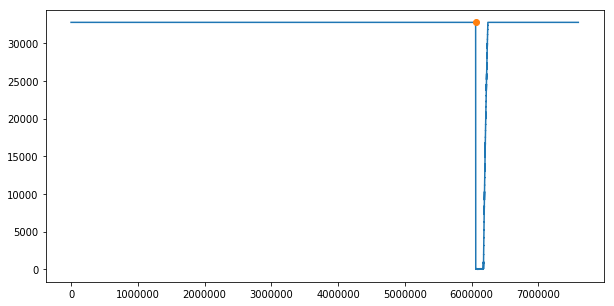

In [918]:
start_frame_num, stop_frame_num = start_stop[no-1]

trigger_ind = np.where(tracks[0, :]<30000)[0][0]
trigger_sec = trigger_ind / sample_freq

start_ind = int(trigger_ind - sample_freq * (mov_frame_count - start_frame_num) / mov_fps)
stop_ind = int(trigger_ind - sample_freq * (mov_frame_count - stop_frame_num) / mov_fps)

cropped_tracks = tracks[:, start_ind:stop_ind]

plt.figure(figsize=(10, 5))
plt.plot(tracks[0, :])
# plt.plot(range(trigger_ind, trigger_ind+1000), 20000*np.ones(1000), 'o')
plt.plot(trigger_ind, tracks[0, 0], 'o')
plt.show()

In [919]:
print(tracks.shape[1] / sample_freq)
print(trigger_ind/sample_freq)

15.2
12.122748


(16, 516667)


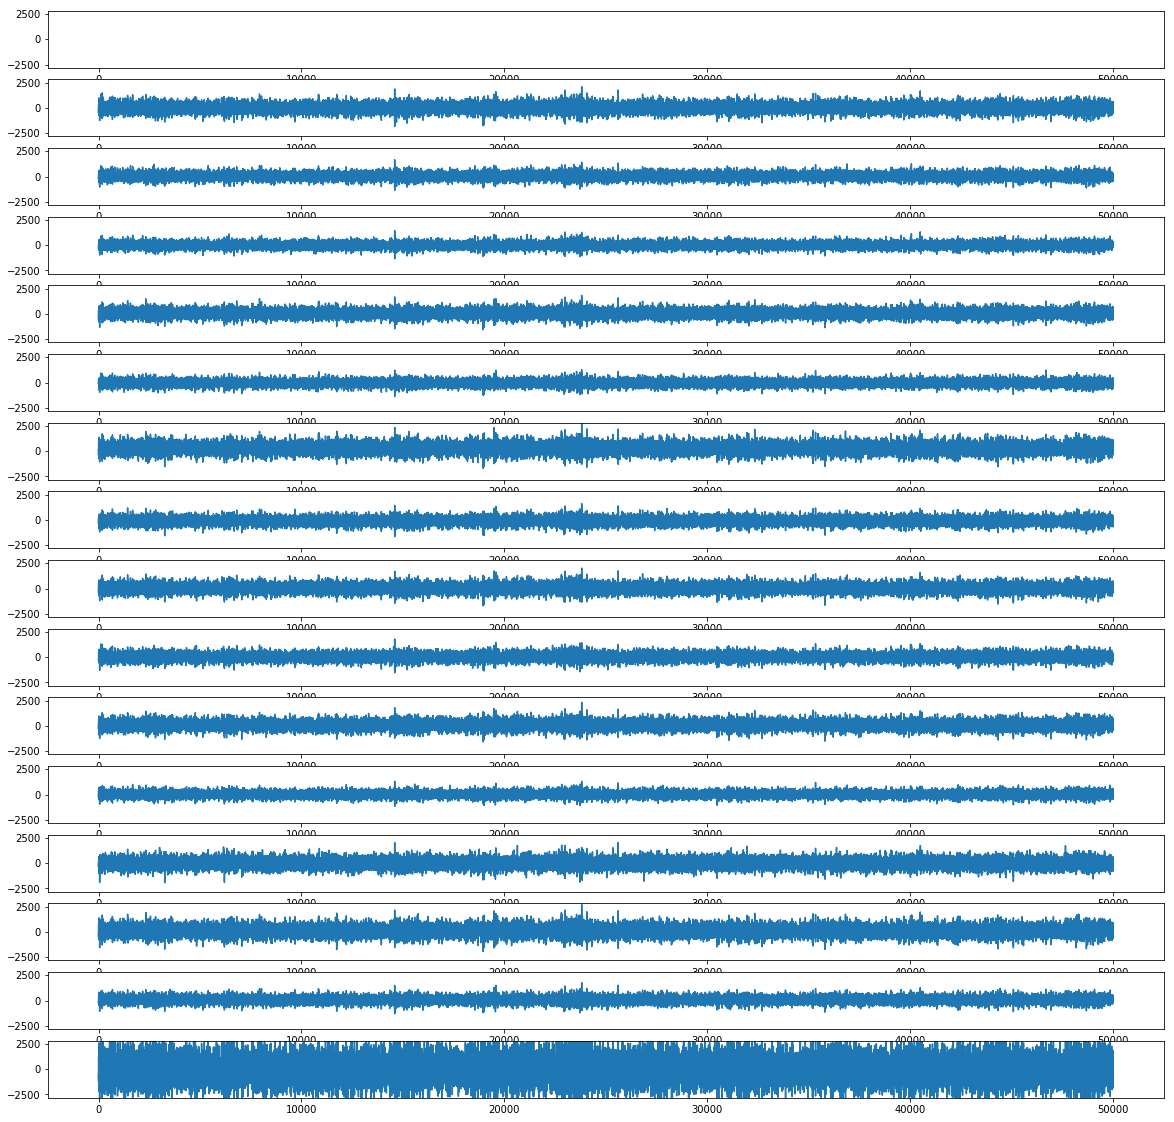

In [920]:
def show_tracks(tracks, start=0, stop=-1): 
    amp_max = max(-np.min(tracks[1:-1]), np.max(tracks[1:-1]))
    plt.figure(figsize=(20, 20), facecolor='white')
    for i in range(16):
        plt.subplot(16, 1, i+1)
#         plt.plot(tracks[i, 2400000:2500000])
        plt.plot(tracks[i])
        plt.ylim([-amp_max, amp_max])

    plt.show()
    
    
def extract_signal(raw_tracks, calib_tracks):
    noise = calib_tracks[1:16, :50000]
#     return np.vstack((raw_tracks[0], raw_tracks[1:16] / np.max(noise, axis=1).reshape(15, 1)))
    return np.where(raw_tracks<=np.max(noise), 0, raw_tracks)


signal = extract_signal(cropped_tracks, calib_tracks)
print(signal.shape)
show_tracks(calib_tracks[:, :50000])
# show_tracks(signal)

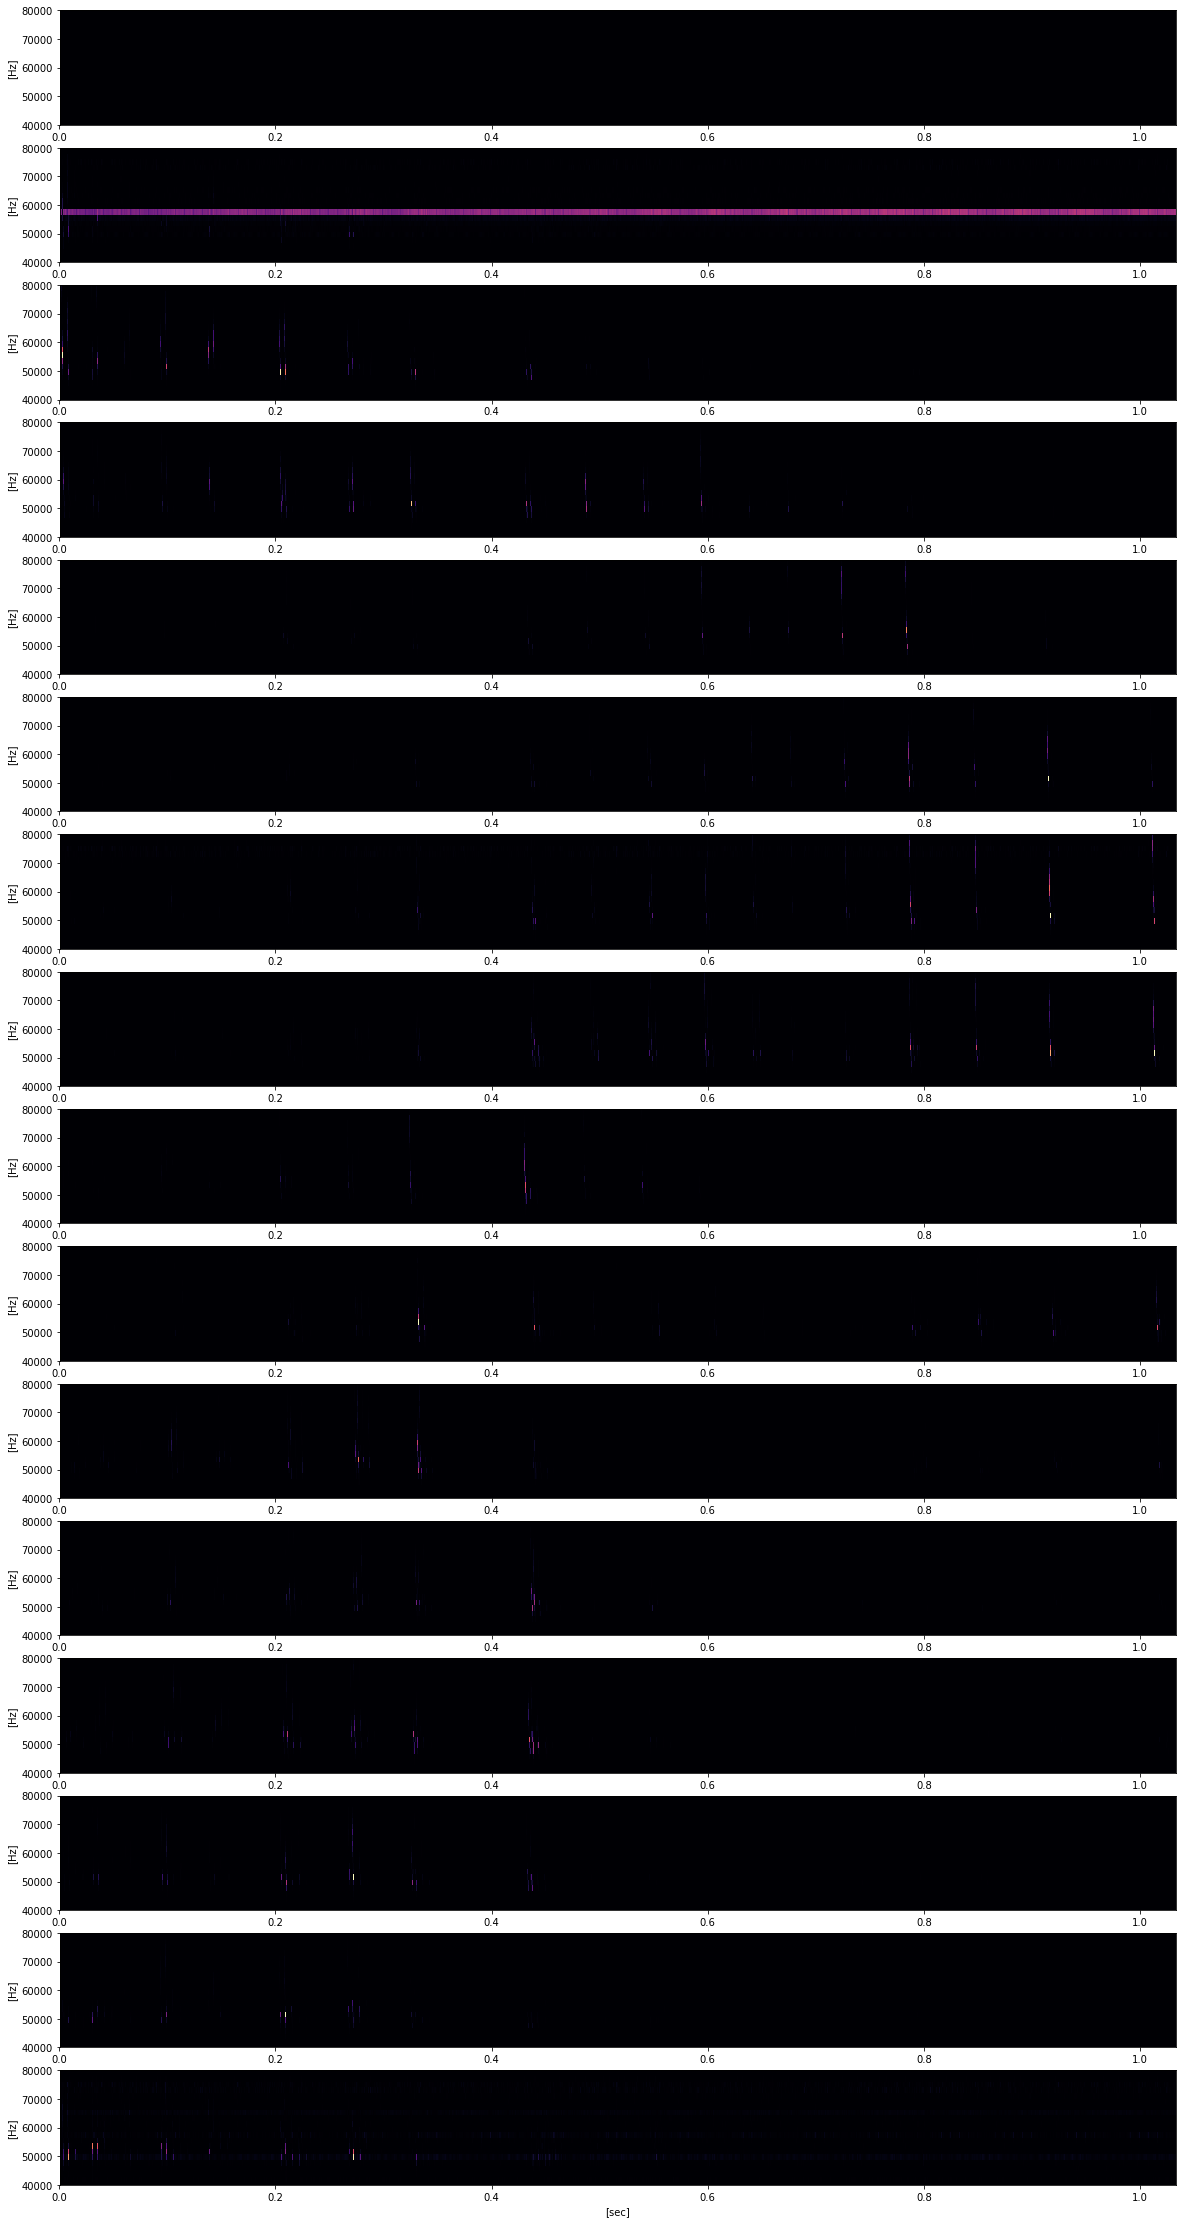

In [921]:
def convert_spectrogram(audio_tracks, sample_frequency=500e3):
    spectro = []
    plt.figure(figsize=(20, 40), facecolor='white')
    
    for i, track in enumerate(audio_tracks):
        f, t, Sxx = sig.spectrogram(track, fs=500e3)
        spectro.append(Sxx)
        
        plt.subplot(audio_tracks.shape[0], 1, i+1)
        plt.pcolormesh(t, f, Sxx, cmap='magma')
        # plt.xlim([0.0, 0.2])
        plt.ylim([40e3, 80e3])
#         plt.ylim([0, 50000])
        plt.xlabel('[sec]')
        plt.ylabel('[Hz]')
    plt.show()       
                   
    return np.array(spectro), f, t


spects, f, t = convert_spectrogram(cropped_tracks)

/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


(16, 2306)


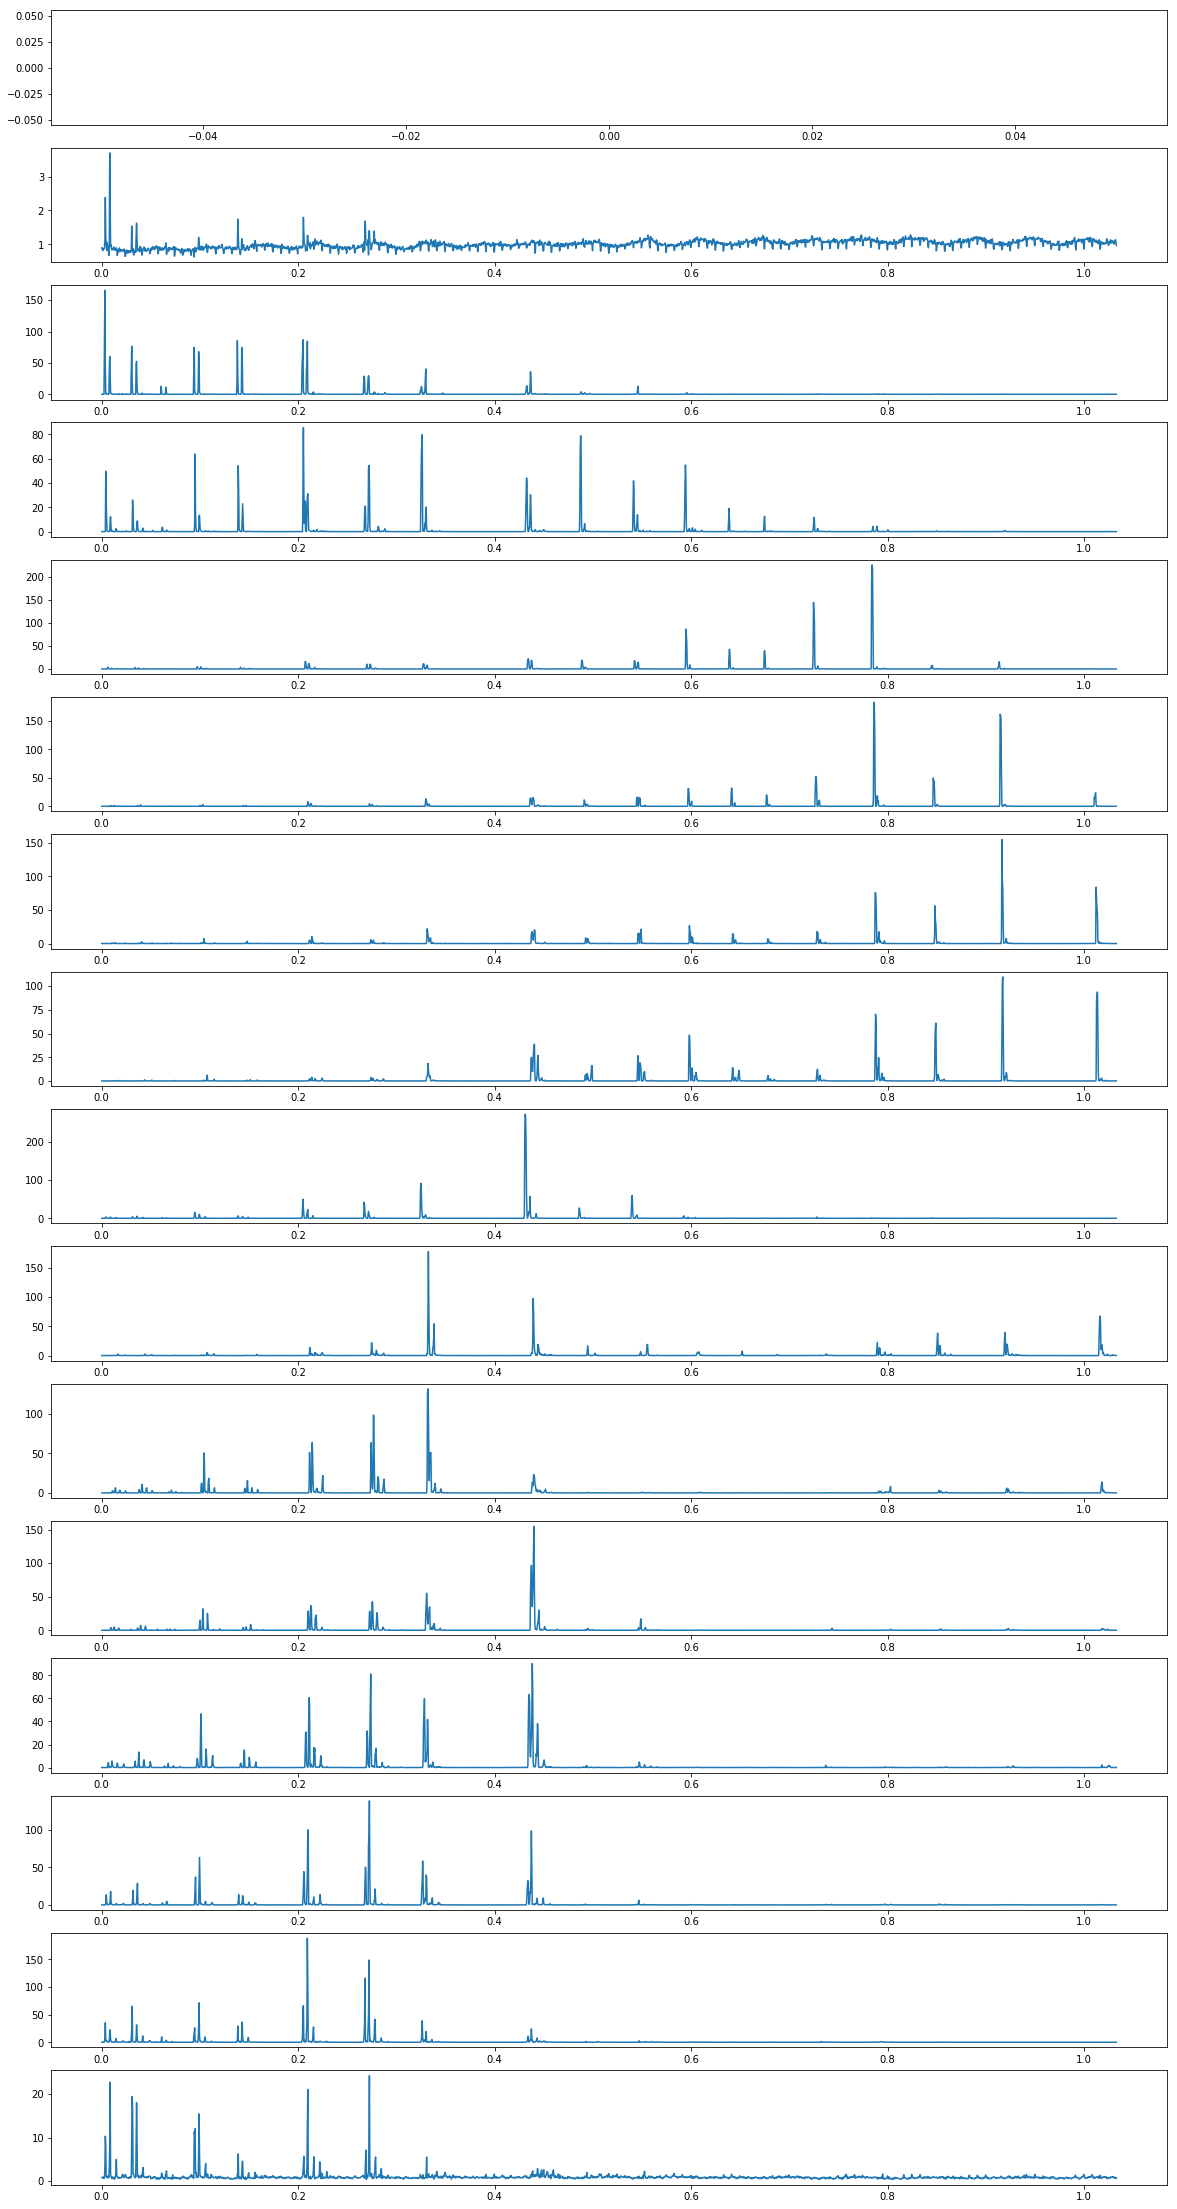

In [924]:
def sum_freq(spectrograms, freqs, band=(45000, 70000)):
    band_sums = []
    band_ind = np.where((band[0] <= freqs) & (freqs <= band[1]))[0]
    for i, spectro in enumerate(spectrograms):
        av = np.average(spectro[band_ind[0]:band_ind[-1]], axis=0)
        band_sums.append(av / np.average(av))
#         band_sums.append(np.average(spectro[band_ind[0]:band_ind[-1]], axis=0))
#         band_sums.append(np.sum(spectro[band_ind[0]:band_ind[-1]], axis=0))
    return np.array(band_sums)

    
band_sums = sum_freq(spects, f)
print(band_sums.shape)

plt.figure(figsize=(20, 40), facecolor='white')
for i, spectro in enumerate(band_sums):
    plt.subplot(band_sums.shape[0], 1, i+1)
    plt.plot(t, spectro)
#         plt.ylim([0, 300])
plt.show()

In [923]:
mic_points = np.array(
    [[4.5, z] for z in range(4, 9)] + \
    [[4.1, 9], [3.3, 9], [2.7, 7.5], [1.8, 9], [0.9, 9]] + \
    [[0, 8-z] for z in range(5)]
)
print(mic_points)
print(mic_points.shape)

[[4.5 4. ]
 [4.5 5. ]
 [4.5 6. ]
 [4.5 7. ]
 [4.5 8. ]
 [4.1 9. ]
 [3.3 9. ]
 [2.7 7.5]
 [1.8 9. ]
 [0.9 9. ]
 [0.  8. ]
 [0.  7. ]
 [0.  6. ]
 [0.  5. ]
 [0.  4. ]]
(15, 2)


In [888]:
mic_points

array([[4.5, 4. ],
       [4.5, 5. ],
       [4.5, 6. ],
       [4.5, 7. ],
       [4.5, 8. ],
       [4.1, 9. ],
       [3.3, 9. ],
       [2.7, 7.5],
       [1.8, 9. ],
       [0.9, 9. ],
       [0. , 8. ],
       [0. , 7. ],
       [0. , 6. ],
       [0. , 5. ],
       [0. , 4. ]])

In [889]:
xls_sheets_path = processed_path / '190526'

no1_xyzt = load_xyz_from_exl(xls_sheets_path / 'no1_bat298.xls')
no2_xyzt = load_xyz_from_exl(xls_sheets_path / 'no2_bat298.xls')
no3_xyzt = load_xyz_from_exl(xls_sheets_path / 'no3_bat298.xls')
no5_xyzt = load_xyz_from_exl(xls_sheets_path / 'no5_bat298.xls')
no1_xyzt.head()

def preprocess(df):
    d = {
        'x': polyfit(df['t'][:-1], df['x'][:-1]),
        'y': polyfit(df['t'][:-1], df['y'][:-1]),
        'z': polyfit(df['t'][:-1], df['z'][:-1]),
        't': df['t'][:-1]
    }
    return pd.DataFrame(data=d)

no1_xyzt = preprocess(no1_xyzt)
no2_xyzt = preprocess(no2_xyzt)
no3_xyzt = preprocess(no3_xyzt)
no5_xyzt = preprocess(no5_xyzt)

../libs/load_bat_line.py:32: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x[:-1], y[:-1], 10)
../libs/load_bat_line.py:32: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x[:-1], y[:-1], 10)
../libs/load_bat_line.py:32: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x[:-1], y[:-1], 10)


/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


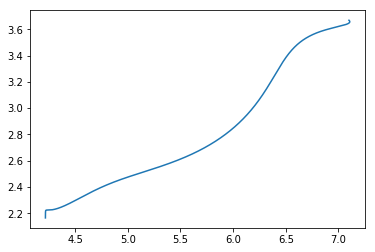

In [911]:
def complement_bat_line(df, band_sums, frame_start, frame_stop):
    x, z = df['x'], df['z']
    frame_num = np.arange(frame_start, frame_stop+1)
    
    coef_x = np.polyfit(frame_num, x, 10)
    coef_z = np.polyfit(frame_num, z, 10)
    
    fx = np.poly1d(coef_x)
    fz = np.poly1d(coef_z)
    
    t_ = np.linspace(frame_start, frame_stop, num=band_sums.shape[1])
    return fx(t_), fz(t_), t_


x, z, t_comp = complement_bat_line(no1_xyzt, band_sums, start_frame_num, stop_frame_num)

x = 4.5 - (x + 1000) / 1000
z = 9 - (3000 - z) / 1000

plt.plot(z, x)

(15, 2306, 2)
(15, 2306, 2)


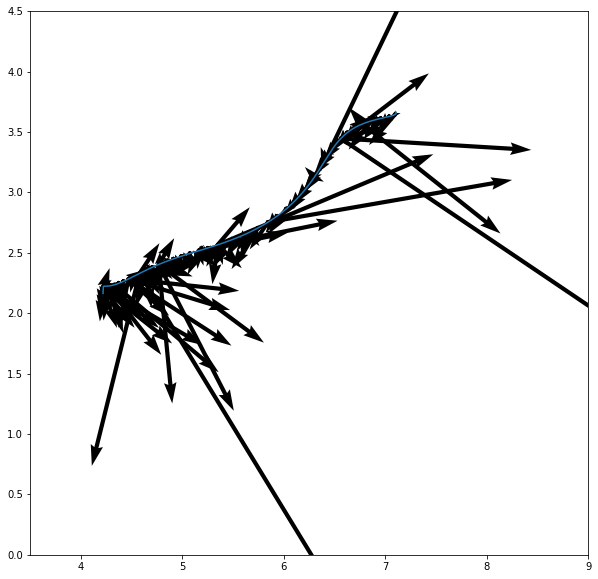

In [912]:
def cal_vectors_to_mic(x, z, t, mic_points):
    vectors = []
    for mic_point in mic_points:
        mic_x, mic_z = mic_point
        vec_x = mic_x - x
        vec_z = mic_z - z
        vector = np.array([vec_z, vec_x]).T
        vector_lengths = np.sqrt(vec_z**2 + vec_x**2).reshape(vector.shape[0], 1)
        unit_vector = vector / vector_lengths 
        vectors.append(unit_vector)
        
    return np.array(vectors)

vectors = cal_vectors_to_mic(x, z, t, mic_points)
print(vectors.shape)


def weight_vectors(weights, vectors):
    w_vectors = []
    for w, v in zip(weights, vectors):
        w_v = v * w.reshape(w.shape[0], 1) 
        w_vectors.append(w_v)
        
    return np.array(w_vectors)

    
w_vectors = weight_vectors(band_sums[1:], vectors)
print(w_vectors.shape)

plt.figure(figsize=(10, 10), facecolor='white')
plt.plot(z, x)

for j in range(1, 15):
    for i in range(0, 2300, 50):
        plt.quiver(z[i], x[i], w_vectors[j, i, 0], w_vectors[j, i, 1], scale=20)

plt.ylim([0, 4.5])
plt.xlim([3.5, 9])
plt.show()


(2306, 2)


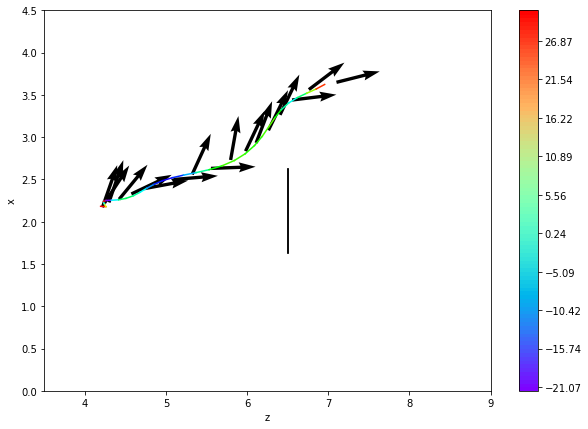

In [972]:
def cal_pulse_vectors(weighted_vectors, thresh=50):
    vector_sums = np.sum(weighted_vectors, axis=0)
    lengths = np.sqrt(vector_sums[:, 0]**2 + vector_sums[:, 1]**2).reshape(vector_sums.shape[0], 1)
#     plt.hist(lengths, bins=np.arange(0, 10000, 10))
#     plt.xlim([0, 1000])
    
    sparse_vec = np.where(lengths>thresh, 1, 0).reshape(vector_sums.shape[0], 1)
    unit_pulse_vector = sparse_vec*(vector_sums / lengths)
#     unit_pulse_vector = vector_sums / lengths
#     unit_pulse_vector = vector_sums
    return unit_pulse_vector

def avoid_echo(pulse_vectors, time, avoid_range=0.05): 
    avoid_range_ind = int(avoid_range/time[1]-time[0])
    
    i = 0
    while i < pulse_vectors.shape[0]:
        if pulse_vectors[i, 0] > 0 or pulse_vectors[i, 1] > 0:
            pulse_vectors[i+1:i+avoid_range_ind, :] = 0
            i += avoid_range_ind
        else:
            i += 1
    return pulse_vectors

    

p_vectors = cal_pulse_vectors(w_vectors)
print(p_vectors.shape)
# for i in p_vectors:
#     print(i)

pulse = avoid_echo(p_vectors, t)

# plt.figure(figsize=(10, 10), facecolor='white')
# plt.plot(z, x)

line_2d_plot(no1_xyzt, s_or_a=2)

# plot obstacle
ob_x = np.linspace(2.125 - 0.5, 2.125 + 0.5, 100)
ob_z = 6.5 * np.ones(100)
plt.plot(ob_z, ob_x, color='black')


ind = np.where((pulse[:, 0]!=0) | (pulse[:, 1]!=0))[0]
plt.quiver(z[ind], x[ind], pulse[ind, 0], pulse[ind, 1], scale=10)

plt.ylim([0, 4.5])
plt.xlim([3.5, 9])
plt.show()

In [950]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

def line_2d_plot(df, s_or_a=None): 
    '''
    plot line 2D
    
    parameters
    ----------
    df: pandas DataFrame
    s_or_a: int, 1 or 2 means 'speed' or 'acceleration'.
    '''
    xs = 4.5 - (df['x'] + 1000) / 1000
    zs = 9 - (3000 - df['z']) / 1000
    xs = np.array(xs[:-1])
    zs = np.array(zs[:-1])

    fig = plt.figure(figsize=(10, 7), facecolor='white')
    plt.plot(zs[0], xs[0], 'o' , color='orange')
    
    if s_or_a in [1, 2]:
        dt = np.abs(df['t'][1] - df['t'][0])
        ds = cal_derivative(xs, zs, dt, s_or_a)
            
        mymap = LinearSegmentedColormap.from_list('rainbow', ['blue', 'red'])
        
        levels = np.linspace(ds.min(), ds.max(), num=100)
        CS3 = plt.contourf([[0, 0], [0, 0]], levels, cmap='rainbow')
        plt.clf()
        
        for x1, x2, y1, y2, d in zip(zs[:-1], zs[1:], xs[:-1], xs[1:], ds):
            # setting rgb color based on z normalized to my range
            r = (d - ds.min()) / (ds.max() - ds.min())
            plt.plot([x1, x2], [y1, y2], color=cm.hsv(r))
        plt.colorbar(CS3) # using the colorbar info I got from contourf
    else:
        plt.plot(zs, xs)
        
    # plot obstacle
    ob_x = np.linspace(2.125 - 0.5, 2.125 + 0.5, 100)
    ob_z = 6.5 * np.ones(100)
    plt.plot(ob_z, ob_x, color='black')

    plt.xlim(3.5, 9)
    plt.ylim(0, 4.5)
    plt.xlabel('z')
    plt.ylabel('x')
   
#     plt.show()

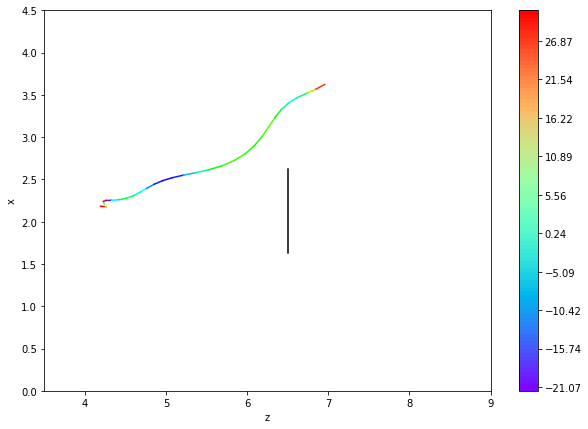